In [2]:
!pip install py2neo


  Obtaining dependency information for py2neo from https://files.pythonhosted.org/packages/b6/e5/d97c8adbda3b9a6957c572f05a8427661194832d4709b90c108b7e868268/py2neo-2021.2.4-py2.py3-none-any.whl.metadata
  Obtaining dependency information for interchange~=2021.0.4 from https://files.pythonhosted.org/packages/88/bd/abc58e5a36a28e0e55501f4bc15df74e430f399375b14b83f4ce22a257b4/interchange-2021.0.4-py2.py3-none-any.whl.metadata
  Obtaining dependency information for monotonic from https://files.pythonhosted.org/packages/9a/67/7e8406a29b6c45be7af7740456f7f37025f0506ae2e05fb9009a53946860/monotonic-1.6-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pansi>=2020.7.3 from https://files.pythonhosted.org/packages/0b/15/7972e08b7ec14a8b10d5ff206c644d4478906c909c134123ed7e6bd16724/pansi-2020.7.3-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/177.2 kB ? eta -:--:--
   ---------------- ----------------------- 71.7/177.2 kB 2.0 MB/s eta 0:00:01
   --

ConnectionUnavailable: Connection has been closed

In [2]:
import py2neo

In [2]:
import pandas as pd
import tqdm
import py2neo

# pandas to read_csv , header = True
characters = pd.read_csv("C:/Users/Georgiana/Downloads/characters.csv")
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu3")

# CONSTRAINT if condition (here n.id_ is unique) not respected => error
# If constraint already exists pass (IF NOT EXISTS probably works too)
try:
    graph.run("CREATE CONSTRAINT ON (n:Superhero) ASSERT n.id_ IS UNIQUE")
except:
    print("Constraint already exists")

# Init the list that will contains dicts for each node
transaction_list = []

# iterrows = line by line iterators of the df row[0] = id row[1] = the variables in columns
for row in tqdm.tqdm(characters.iterrows()):
    id_ = row[1]["characterID"]
    name = row[1]["name"]
    transaction_list.append({"id_":id_,"name":name})
    # Commit when list = 1000, vary it depending of the case
    if len(transaction_list) == 1000:
        # UNWIND = split the list given to it (here $json because json=transaction_list)
        # For each dict do the following query CREATE (n:Superhero) SET n = data
        transaction = "UNWIND $json as data CREATE (n:Superhero) SET n = data"
        graph.run(transaction, json=transaction_list)
        transaction_list = []

# Some observation left (e.g 7700 node, will commit every 100. so 700 left)
graph.run(transaction, json=transaction_list)

pass

1170it [00:00, 1606.78it/s]


In [3]:
import pandas as pd
import py2neo

stats = pd.read_csv("C:/Users/Georgiana/Downloads/characters_stats.csv")
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu3")


# OPTIONAL MATCH =>  search for the pattern described in it, while using nulls for missing parts of the pattern.
transaction = """UNWIND $json as data
OPTIONAL MATCH (a:Superhero {name:data.Name})
SET a += {Alignement:data.Alignement,Intelligence:data.Intelligence,Strength:data.Strength,Speed:data.Speed,Durability:data.Durability,
         Power:data.Power,Combat:data.Combat,Total:data.Total} 
"""

transaction_list = []

iteration = 0
for row in tqdm.tqdm(stats.iterrows()):
    transaction_list.append(dict(row[1]))
    iteration += 1
    if iteration % 1000 == 0:
        graph.run(transaction, json=transaction_list)
        transaction_list = []
        
graph.run(transaction, json=transaction_list)

pass

611it [00:00, 6639.79it/s]


In [4]:
import pandas as pd
import tqdm
import py2neo
import itertools

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu3")

characters2comics = pd.read_csv("C:/Users/Georgiana/Downloads/charactersToComics.csv")
characters2comics = characters2comics.drop_duplicates()
transaction_list = []

# MERGE = if pattern does not exists ON CREATE
# If pattern exists do ON MATCH



transaction = """UNWIND $json as data
MATCH (a:Superhero),(b:Superhero)
WHERE a.id_ = data.id_1 AND b.id_ = data.id_2
MERGE (a)-[r:RELATION]->(b)
ON CREATE
    SET r.n_collab = 1
ON MATCH
    SET r.n_collab = r.n_collab + 1
"""

it = 0   
for comic in tqdm.tqdm(characters2comics.groupby(["comicID"])):
    related_ids = comic[1]["characterID"]
    for combi in list(itertools.combinations(related_ids, 2)):
        sh1 = combi[0]
        sh2 = combi[1]
        transaction_list.append({"id_1":sh1,"id_2":sh2})
        it +=1
        if it % 1000 == 0:
            graph.run(transaction, json=transaction_list)
            transaction_list = []

graph.run(transaction, json=transaction_list)
pass

100%|██████████████████████████████████████████████████████████████████████████| 22250/22250 [00:17<00:00, 1280.99it/s]


In [5]:
import py2neo

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu3")

query = """MATCH (a:Superhero{name:'Pepper Potts'})-[r:RELATION]-(b:Superhero{name:'Iron Man'}) RETURN r,a,b"""
data = graph.run(query).to_data_frame()
print(data["r"],data["a"],data["b"])

0    {'n_collab': 68}
Name: r, dtype: object 0    {'name': 'Pepper Potts', 'id_': 1009494}
Name: a, dtype: object 0    {'Speed': 58, 'Intelligence': 100, 'id_': 1009...
Name: b, dtype: object


### Exercises

### CRUD operations:


**1**: You will continue to work on the MCU network for a while. Who are the 10 fastest in the MCU ? Are they related to each other ?

**2**: How many have collaborated atleast more than 10 times with another superhero?

**3**: Did the weakest of the MCU collaborated with the strongest ?

**4**: Give a stats that interests you !

**5**: Create a new db called "master". Create a graph from the M1 class with name and random age between 20 and 30, Group of 3 that collab (undirected relation).

**6**: Get the age for people YOU collaborate with.

**7**: Get nodes with age > 25.


### 1: You will continue to work on the MCU network for a while. Who are the 10 fastest in the MCU ? Are they related to each other ?

In [8]:

import py2neo
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu3")
query=""" MATCH (a:Superhero)
WHERE exists(a.Speed)
RETURN a
ORDER BY a.Speed DESC
LIMIT 10
"""
data=graph.run(query).to_data_frame()
list(data["a"])

[Node('Superhero', Combat=56, Durability=84, Intelligence=75, Power=100, Speed=100, Strength=67, Total=482, id_=1009184, name='Black Bolt'),
 Node('Superhero', Combat=85, Durability=110, Intelligence=88, Power=100, Speed=100, Strength=85, Total=568, id_=1010764, name='Stardust'),
 Node('Superhero', Combat=56, Durability=60, Intelligence=63, Power=57, Speed=100, Strength=28, Total=364, id_=1009524, name='Quicksilver'),
 Node('Superhero', Combat=25, Durability=100, Intelligence=38, Power=100, Speed=100, Strength=60, Total=423, id_=1009477, name='Nova'),
 Node('Superhero', Combat=85, Durability=100, Intelligence=69, Power=100, Speed=92, Strength=100, Total=546, id_=1009664, name='Thor'),
 Node('Superhero', Combat=32, Durability=101, Intelligence=63, Power=100, Speed=84, Strength=100, Total=480, id_=1009592, name='Silver Surfer'),
 Node('Superhero', Combat=70, Durability=100, Intelligence=100, Power=100, Speed=83, Strength=100, Total=553, id_=1009312, name='Galactus'),
 Node('Superhero', C

### 2: How many have collaborated atleast more than 10 times with another superhero?

In [4]:

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu3")
query = """
MATCH (a:Superhero)-[r:RELATION]-(b:Superhero)
WHERE r.n_collab > 10
RETURN COUNT(DISTINCT a) AS collaborations
LIMIT 10
"""

# Exécution de la requête et récupération des résultats
data = graph.run(query).to_data_frame()

# Récupération du nombre de collaborations à partir des résultats
collabs = list(data["collaborations"])

# Affichage du résultat
print("Le nombre de superhéros qui ont collaboré plus de 10 fois avec d'autres:", collabs[0])

Le nombre de superhéros qui ont collaboré plus de 10 fois avec d'autres: 528


### 3:  Did the weakest of the MCU collaborated with the strongest ?

In [7]:

query = """
MATCH( a:Superhero), (b:Superhero)
WITH MIN(a.Strength) AS minStrength, MAX(a.Strength) AS maxStrength
MATCH (a:Superhero {Strength:minStrength}), (b:Superhero{Strength:maxStrength})
OPTIONAL MATCH (a)-[r:RELATION]-(b)
WITH a.name AS Weakest, b.name AS Strongest, COUNT(r) AS CollabCount
WHERE CollabCount=1
RETURN Weakest, Strongest, CollabCount
"""

# Exécution de la requête et récupération des résultats
data = graph.run(query).to_data_frame()

# Affichage du résultat
print(data)

             Weakest   Strongest  CollabCount
0   Lady Deathstrike        Hulk            1
1   Lady Deathstrike        Thor            1
2   Lady Deathstrike  Apocalypse            1
3          Omega Red  Apocalypse            1
4          Omega Red  Juggernaut            1
..               ...         ...          ...
91           Stacy X        Thor            1
92           Stacy X  Wonder Man            1
93           Stacy X    Hercules            1
94           Stacy X  Juggernaut            1
95              Beak  Juggernaut            1

[96 rows x 3 columns]


### 4: Give a stats that interests you !
### What are the top five most powerful superheroes?

In [8]:

query=""" MATCH (a:Superhero)
WHERE exists(a.Power)
RETURN a
ORDER by a.Power DESC
LIMIT 5
"""
data=graph.run(query).to_data_frame()
list(data["a"])


[Node('Superhero', Combat=32, Durability=101, Intelligence=63, Power=100, Speed=84, Strength=100, Total=480, id_=1009592, name='Silver Surfer'),
 Node('Superhero', Combat=64, Durability=85, Intelligence=100, Power=100, Speed=58, Strength=85, Total=492, id_=1009368, name='Iron Man'),
 Node('Superhero', Combat=100, Durability=100, Intelligence=50, Power=100, Speed=30, Strength=15, Total=395, id_=1009268, name='Deadpool'),
 Node('Superhero', Combat=70, Durability=100, Intelligence=100, Power=100, Speed=83, Strength=100, Total=553, id_=1009312, name='Galactus'),
 Node('Superhero', Combat=70, Durability=100, Intelligence=100, Power=100, Speed=67, Strength=80, Total=517, id_=1009327, name='Jean Grey')]

### 5: Create a new db called "master". Create a graph from the M1 class with name and random age between 20 and 30, Group of 3 that collab (undirected relation).

In [11]:
import random
from py2neo import Graph, Node, Relationship
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="master")


# Noms des personnes
person_names = [
    "Sacha", "Oumou", "Georgiana", "Valentin", "Benie", 
    "Huyiue", "Romain", "Adrien", "Werner", "Paul", 
    "Lath", "Carl", "Celestin", "Nathan", "Julien"
]

# Fonction pour créer un nœud de la classe M1 avec un nom spécifique et un âge aléatoire
def create_m1_node(name):
    age = random.randint(20, 30)
    return Node("M1", name=name, age=age)

# Création des nœuds de la classe M1 avec les noms spécifiques
m1_nodes = [create_m1_node(name) for name in person_names]

# Randomly shuffle the nodes
random.shuffle(m1_nodes)

# Create collaboration relationships for each person with three others
for node in m1_nodes:
    # Ensure there are at least 3 other nodes available to collaborate with
    available_collaborators = [n for n in m1_nodes if n != node]
    random.shuffle(available_collaborators)
    collaborators = available_collaborators[:3]
    for collaborator in collaborators:
        # Ensure that the collaboration relationship is unidirectional
        if not graph.exists(Relationship(collaborator, "COLLABORATE_WITH", node)):
            rel = Relationship(node, "COLLABORATE_WITH", collaborator)
            graph.create(rel)

# Ajout des nœuds M1 au graphe
for node in m1_nodes:
    graph.create(node)

### 6: Get the age for people YOU collaborate with.

In [16]:

georgiana_name = "Georgiana"

query = """
MATCH (g:M1 {name: $georgiana_name})-[:COLLABORATE_WITH]->(collaborator)
RETURN collaborator.name AS collaborator_name, collaborator.age AS collaborator_age
"""

# Execute the query
result = graph.run(query, georgiana_name=georgiana_name)

# Retrieve and print the ages of people Georgiana collaborates with
for record in result:
    collaborator_name = record["collaborator_name"]
    collaborator_age = record["collaborator_age"]
    print(f"{collaborator_name}: {collaborator_age} years old")

Celestin: 28 years old
Werner: 29 years old
Huyiue: 25 years old


### 7: Get nodes with age > 25.

In [17]:
query = """
MATCH (n:M1)
WHERE n.age > 25
RETURN n.name AS name, n.age AS age
"""

# Execute the query
result = graph.run(query)

# Retrieve and print the nodes with age > 25
for record in result:
    name = record["name"]
    age = record["age"]
    print(f"{name}: {age} years old")

Adrien: 28 years old
Romain: 30 years old
Nathan: 26 years old
Werner: 29 years old
Valentin: 29 years old
Celestin: 28 years old
Georgiana: 28 years old


### Real world problem:
8: Using the downloaded data in TODO 11 of chapter II, create a collaboration network between authors for papers after 2021 (same author if same name). Insert it in neo4j in a db called "arxiv".

9: Get the density of degrees of the collaboration network

10: Do a for loop for i in range(500) for each i remove nodes with a degree less than i.

### 8: Using the downloaded data in TODO 11 of chapter II, create a collaboration network between authors for papers after 2021 (same author if same name). Insert it in neo4j in a db called "arxiv".

In [15]:
import requests
import feedparser
import tqdm
import time
import pymongo
import csv
from pymongo import MongoClient

client = pymongo.MongoClient('localhost',27017)
mydb = client["tutorial"]
collection = mydb["arxiv_api"]
arxivapi = collection.find()

with open('arxivapi.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['id', 'title', 'authors', 'published', 'published_parsed']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for document in arxivapi:
        writer.writerow({'id': document['id'], 'title': document['ttle'], 'authors': document['authors'], 'published': document['published'], 'published_parsed': document['published_parsed']})
        

In [49]:
import py2neo
from py2neo import ogm
import numpy as np
from py2neo import Graph, Node, Relationship
import csv

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="arxiv1")
csv_file = "C:/Users/Georgiana/NoSql/arxivapi.csv"

with open(csv_file, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:

        published_year = row['published_parsed'][0]
        
        # Vérifier si l'article a été publié après 2021
        if published_year > "2021":
            # Extraire les auteurs de la colonne "authors"
            authors = row['authors']
            author_names = [author.strip().split(':')[1].strip() for author in authors.split(',') if 'name' in author]
            
            # Créer un nœud pour chaque auteur s'il n'existe pas déjà
            for author_name in author_names:
                author_node = Node("Author", name=author_name)
                graph.merge(author_node, "Author", "name")
            
            # Créer des liens de collaboration entre tous les auteurs de l'article
            for i in range(len(author_names)):
                for j in range(i + 1, len(author_names)):
                    author1_node = graph.nodes.match("Author", name=author_names[i]).first()
                    author2_node = graph.nodes.match("Author", name=author_names[j]).first()
                    if author1_node and author2_node:
                        collab_rel = Relationship(author1_node, "COLLABORATE", author2_node)
                        graph.merge(collab_rel)

KeyboardInterrupt: 

### 9: Get the density of degrees of the collaboration network

C:\Users\Georgiana\AppData\Local\Temp\ipykernel_3996\3684943852.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(collaborations, hist=False)


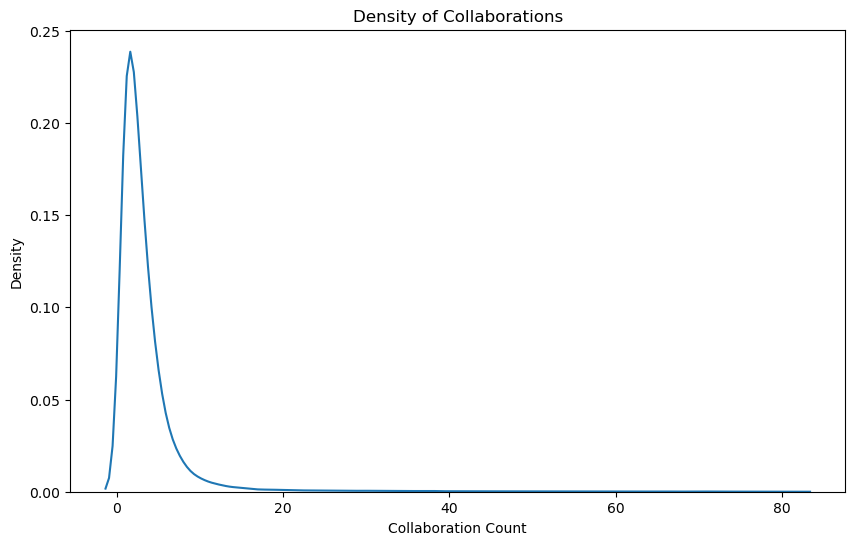

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="arxiv1")
query="""
MATCH (a:Author)-[:COLLABORATE]->(b:Author)
RETURN a.name AS author, COUNT(b) AS collaboration_count
"""

# Exécution de la requête et récupération des résultats
result = graph.run(query)

# Extraction des collaborations par auteur
collaborations = [record["collaboration_count"] for record in result]

# Tracé de la densité des collaborations
plt.figure(figsize=(10, 6))
ax = sns.distplot(collaborations, hist=False)
ax.set_title("Density of Collaborations")
ax.set_xlabel("Collaboration Count")
ax.set_ylabel("Density")
plt.show()

### 10: Do a for loop for i in range(500) for each i remove nodes with a degree less than i.

In [62]:
for i in range(500):
    # Construction de la requête Cypher pour supprimer les relations avec un degré inférieur à i
    query = f"""
    MATCH (a:Author)-[r:COLLABORATE]-()
    WHERE size((a)-[:COLLABORATE]-()) < {i}
    DELETE r
    """
    graph.run(query)
    
    # Construction de la requête Cypher pour supprimer les nœuds avec un degré inférieur à i
    query = f"""
    MATCH (a:Author)
    WHERE size((a)-[:COLLABORATE]-()) < {i}
    DETACH DELETE a
    """
    graph.run(query)

### Real World application 3

You will work again on [pubmed_last_100k.json](https://we.tl/t-6afLCDGRsg). The goal in this homework is to insert collaboration data in Neo4j and then study it using cypher queries. The following questions are meant to guide you through the process.

1) Each paper has a list of author and affiliations. The first step is to create a node per author with a list of affiliation as attribute. If a name appears multiple times consider it as a single person. Create an edge between two authors if they are on the same paper. You can use any kind of operation to clean the data before inserting, you decide which preprocessing step is the most convenient.

2) How many authors have more than 2 affiliations ?

3) Create a density of node degrees. Do you observe a power scale law ? What does it mean ?

4) Which country has seen the most international collaboration ?

5) Who are the top 10 collaborators and what is their affiliation ?

6) Sandbox exercise: think of a problematic and try to answer it.

### 1: Each paper has a list of author and affiliations. The first step is to create a node per author with a list of affiliation as attribute. If a name appears multiple times consider it as a single person. Create an edge between two authors if they are on the same paper. You can use any kind of operation to clean the data before inserting, you decide which preprocessing step is the most convenient.


In [4]:
import json
import re
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="pubmed")
# Charger le fichier JSON
with open('C:/Users/Georgiana/Downloads/pubmed_cleaned.json', 'r') as json_file:
    data = json.load(json_file)

# Afficher les premières lignes du JSON
print(data[:5])


[{'_id': {'$oid': '60c715b4c4b7559e04fd9d24'}, 'pmid': 30006494, 'title': 'Proton pump inhibitors and gastric cancer: association is not causation.', 'ISSN': '1468-3288', 'abstract': None, 'meshwords': 'Anti-Ulcer Agents \nHelicobacter pylori \nHumans \nProton Pump Inhibitors \nStomach Neoplasms ', 'meshsubwords': '', 'authors': "name ml Moayyedi P, affil str Division of Gastroenterology and Farncombe Family Digestive Health Research Institute, McMaster University, Hamilton, Ontario, Canada.\nname ml Veldhuyzen van Zanten SJO, affil str Division of Gastroenterology, University of Alberta, Edmonton, Alberta, Canada.\nname ml Hookey L, affil str Division of Gastroenterology, Queen\\'s University, Kingston, Ontario, Canada.\nname ml Armstrong D, affil str Division of Gastroenterology and Farncombe Family Digestive Health Research Institute, McMaster University, Hamilton, Ontario, Canada.\nname ml Jones N, affil str Division of Gastroenterology, Hepatology, and Nutrition, The Hospital for 

In [ ]:
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="pubmed")
for entry in data:
    # Extraire le titre de l'article
    title = entry['title']
    
    # Extraire les noms et les affiliations des auteurs de l'article actuel
    authors_affiliations = re.findall(r'name ml (.*?), affil str (.*?)\.', entry['authors'])
    
    # Créer un nœud pour chaque auteur avec le titre et l'affiliation comme attributs
    for author, affiliation in authors_affiliations:
        author_node = Node("Author", name=author, title=title, affiliation=affiliation)
        graph.create(author_node)
    
    # Créer des arêtes entre les auteurs qui ont le même titre
    for i in range(len(authors_affiliations)):
        for j in range(i + 1, len(authors_affiliations)):
            author1 = authors_affiliations[i][0]  # Nom du premier auteur
            author2 = authors_affiliations[j][0]  # Nom du deuxième auteur
            graph.run(
                "MATCH (a:Author {name: $author1}), (b:Author {name: $author2}) "
                "CREATE (a)-[:SAME_TITLE]->(b)",
                author1=author1, author2=author2
            )

### 2) How many authors have more than 2 affiliations ?

In [ ]:
query = """
MATCH (a:Author)
WITH a.name AS author_name, a.affiliation AS affiliation, COUNT(DISTINCT a.affiliation) AS num_affiliations
WHERE num_affiliations > 2
RETURN COUNT(DISTINCT author_name) AS num_authors_with_multiple_affiliations
"""

result = graph.run(query).to_data_frame()


### 3)  Create a density of node degrees. Do you observe a power scale law ? What does it mean ?

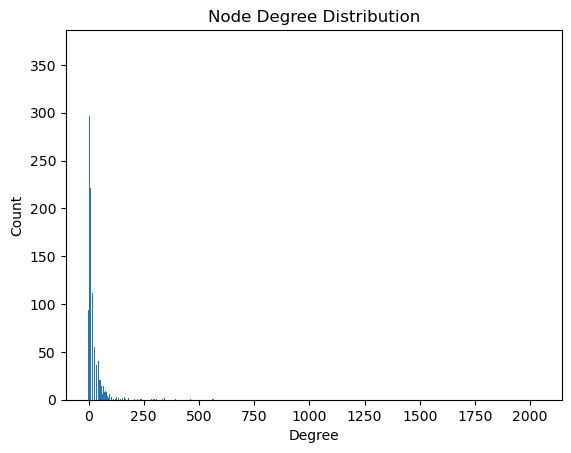

In [48]:

import matplotlib.pyplot as plt
import pandas as pd

query = """
MATCH (n)
WITH n, size((n)--()) AS degree
WITH degree, count(*) AS count
RETURN degree, count
ORDER BY degree
"""
result = graph.run(query)

data = pd.DataFrame([dict(record) for record in result])

plt.bar(data["degree"], data["count"])
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Node Degree Distribution')
plt.show()


### Oui, nous pouvons observer que la distibution suit une loi de puissance: il y a beaucoup de papiers qui ont  peu d'auteurs et tres peu de papiers avec beaucoup d'auteurs, ce qui implique que les collaborations par groupes  reduits sont plus courantes.

### 5) Who are the top 10 collaborators and what is their affiliation?

In [67]:
query = """
MATCH (a:Author)-[:SAME_TITLE]-(:Author)
WITH DISTINCT a, COUNT(DISTINCT id(a)) AS collaborations, COLLECT(DISTINCT a.affiliation) AS affiliations
ORDER BY collaborations DESC
LIMIT 10
RETURN a.name AS Author, affiliations[0] AS Affiliation, collaborations
"""

results = graph.run(query)

# Affichage des résultats
for result in results:
    print("Auteur:", result["Author"])
   

Auteur: Jones N
Auteur: Armstrong D
Auteur: Hookey L
Auteur: Veldhuyzen van Zanten SJO
Auteur: Moayyedi P
Auteur: Trifonov V
Auteur: Martins C
Auteur: Martins C
Auteur: Houben A
Auteur: Leontiadis GI


### 6) Sandbox exercise: think of a problematic and try to answer it.
### Quel est le nombre de papiers relatifs au domaine de la chimie?

In [78]:
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="pubmed")
query = """
MATCH (a:Author)
WHERE toLower(a.title) CONTAINS 'chemistry'
RETURN COUNT(DISTINCT a.title) AS num_papers
"""

# Exécution de la requête
result = graph.run(query)

# Récupération et affichage du nombre de papiers relatifs à la chimie
for record in result:
    num_papers = record["num_papers"]
    print("Number of papers related to chemistry:", num_papers)

Number of papers related to chemistry: 29



### Real World application 4
change the database "neo4j" to the database "movie". Go to the browser and run on the browser console :play movie-graph then copy the queries on the console and run it. Congrats you just imported a brand new sample of data. Answer the following questions with cypher queries.

1. How many actors played in more than 2 movie ? Get their names and year they were born.

2. In how many movies did Tom hanks play ?

3. In average in how many movies do actors play in ?

4. In average how many actors are there in a movie ?

5. In average how many writers is needed to write a movie ?

6. What is the proportion of writers that also directed the movie ?

7. Do an histogram of the year of release for the movies.

8. Who are the 10 actors with the most movie played in

9. Delete every movie made by a director of your choosing

10. Give some statistics that you find interesting.

11. Sandbox exercise: think of a problematic and try to answer it.

# Pour cette partie je n'ai pas réussi à me connecter depuis python. J'ai executé les queries directement sur neo4j et j'ai reporté les résultats ici en format markdown.



### 1:How many actors played in more than 2 movie ? Get their names and year they were born.

In [17]:

import py2neo
from py2neo import ogm
import numpy as np
from py2neo import Graph, Node, Relationship
import csv
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"),name="neo4j")
query = """
MATCH (actor:Person)-[:ACTED_IN]->(movie)
WITH actor, COUNT(movie) AS movieCount
WHERE movieCount > 2
RETURN actor.name AS ActorName, actor.born AS YearOfBirth

"""
results = graph.run(query)



ConnectionUnavailable: Connection has been closed

In [ ]:
Résultats réportés depuis la console neo4j:

ActorName	YearOfBirth
"Keanu Reeves"	1964
"Carrie-Anne Moss"	1967
"Laurence Fishburne"	1961
"Hugo Weaving"	1960
"Tom Cruise"	1962
"Jack Nicholson"	1937
"Kevin Bacon"	1958
"Cuba Gooding Jr."	1968
"Meg Ryan"	1961
"Helen Hunt"	1963
"Robin Williams"	1951
"Tom Hanks"	1956
"Gene Hackman"	1930
"Ben Miles"	1967
"Bill Paxton"	1955
"Keanu Reeves"	1964
"Carrie-Anne Moss"	1967
"Laurence Fishburne"	1961
"Hugo Weaving"	1960
"Tom Cruise"	1962
"Jack Nicholson"	1937
"Kevin Bacon"	1958
"Cuba Gooding Jr."	1968
"Meg Ryan"	1961
"Helen Hunt"	1963
"Robin Williams"	1951
"Tom Hanks"	1956
"Gene Hackman"	1930
"Ben Miles"	1967
"Bill Paxton"	1955 #30 acteurs

### 2: In how many movies did Tom hanks play ?

In [ ]:
# Query executée sur neo4j:
MATCH (tom:Person {name: "Tom Hanks"})-[:ACTED_IN]->(movie)
RETURN COUNT(movie) AS NumberOfMovies 

In [ ]:
NumberOfMovies
36

### 3: In average in how many movies do actors play in ?

In [ ]:
# Query executée sur neo4j:
MATCH (actor:Person)-[:ACTED_IN]->(movie)
WITH actor, COUNT(movie) AS movieCount
RETURN AVG(movieCount) AS AverageMoviesPerActor 

In [ ]:
AverageMoviesPerActor
1.6862745098039214

### 4: In average how many actors are there in a movie ?

In [ ]:
# Query executée sur neo4j:
MATCH (m:Movie)
RETURN AVG(size((m)<-[:ACTED_IN]-(:Person))) AS average_actors_per_movie

In [ ]:
average_actors_per_movie
4.526315789473683

### 5: In average how many writers is needed to write a movie ?

In [ ]:
# Query executée sur neo4j:
MATCH (writer:Person)-[:WROTE]->(movie)
WITH movie, COUNT(writer) AS writerCount
RETURN AVG(writerCount) AS AverageWritersPerMovie 

In [ ]:
AverageWritersPerMovie
1.2608695652173916

### 6: What is the proportion of writers that also directed the movie ?

In [ ]:
# Query executée sur neo4j:
MATCH (writer:Person)-[:WROTE]->(movie)<-[:DIRECTED]-(director:Person)
WITH writer, COUNT(DISTINCT movie) AS totalMovies, COUNT(DISTINCT CASE WHEN writer = director THEN movie END) AS moviesDirectedByWriter
RETURN COUNT(writer) AS totalWriters, SUM(CASE WHEN moviesDirectedByWriter > 0 THEN 1 ELSE 0 END) AS writersWhoDirected,
       toFloat(SUM(CASE WHEN moviesDirectedByWriter > 0 THEN 1 ELSE 0 END)) / COUNT(writer) AS proportion

In [ ]:
totalWriters: 23     	writersWhoDirected: 12	     proportion:  0.5217391304347826


### 7: Do an histogram of the year of release for the movies.

In [ ]:

query = """
MATCH (movie:Movie)
RETURN movie.released.year AS releaseYear, COUNT(*) AS count
ORDER BY releaseYear
"""

# Exécuter la requête et récupérer les données
result = graph.run(query)
data = pd.DataFrame([dict(record) for record in result])

# Créer le graphique à barres
plt.bar(data["releaseYear"], data["count"])
plt.xlabel('Année de sortie')
plt.ylabel('Nombre de films')
plt.title('Histogramme des années de sortie des films')

# Afficher le graphique
plt.show()


### 8: Who are the 10 actors with the most movie played in?

In [ ]:
# Query executée sur neo4j:
MATCH (actor:Person)-[:ACTED_IN]->(movie)
RETURN actor.name AS ActorName, COUNT(movie) AS MovieCount
ORDER BY MovieCount DESC
LIMIT 10

In [ ]:
	ActorName	MovieCount
"Tom Hanks"	36
"Keanu Reeves"	21
"Meg Ryan"	15
"Hugo Weaving"	15
"Jack Nicholson"	15
"Cuba Gooding Jr."	12
"Laurence Fishburne"	9
"Carrie-Anne Moss"	9
"Tom Cruise"	9
"Kevin Bacon"	9

### 9: Delete every movie made by a director of your choosing

In [ ]:
# Query executée sur neo4j:
MATCH (director:Person {name: "Lana Wachowski"})-[:DIRECTED]->(movie:Movie)
DETACH DELETE movie

### 10: Give some statistics that you find interesting.

In [ ]:
query = """
MATCH (movie:Movie)
RETURN size((:Person)-[:ACTED_IN]->(movie)) AS degree
"""
data = graph.run(query).to_data_frame()
ax = sns.distplot(data["degree"],hist=False)
ax.title.set_text("Density of degrees")

### 11: Sandbox exercise: think of a problematic and try to answer it.
### Trouver les acteurs avec lesquels Keanu Reeves n'a pas encore travaillé, mais dont les coacteurs ont travaillé et lui faire des recommandations.

In [ ]:
# Query executée sur neo4j:
MATCH (keanu:Person {name:"Keanu Reeves"})-[:ACTED_IN]->(m)<-[:ACTED_IN]-(coActors),
  (coActors)-[:ACTED_IN]->(m2)<-[:ACTED_IN]-(cocoActors)
WHERE NOT (keanu)-[:ACTED_IN]->()<-[:ACTED_IN]-(cocoActors) AND keanu <> cocoActors
RETURN cocoActors.name AS Recommended, count(*) AS Strength ORDER BY Strength DESC


In [ ]:
Recommended	Strength
"Tom Hanks"	12
"Jim Broadbent"	9
"Halle Berry"	9
"Ben Miles"	9
"Natalie Portman"	9
"John Hurt"	9
"Stephen Rea"	9
"Danny DeVito"	6
"J.T. Walsh"	6
"Cuba Gooding Jr."	6
"Clint Eastwood"	3
"Richard Harris"	3
"Robin Williams"	3
"Nathan Lane"	3
"John C. Reilly"	3
"Helen Hunt"	3
"Greg Kinnear"	3
"James Marshall"	3
"Kevin Pollak"	3
"Aaron Sorkin"	3
"Christopher Guest"	3
"Noah Wyle"	3
"Kiefer Sutherland"	3
"Kevin Bacon"	3
"Demi Moore"	3
"Tom Cruise"	3
"Liv Tyler"	3

### Real World application 5
You will work on a Twitch dataset found here. The goal is to learn more about the feat&fun on Twitch. First thing to do is create the network on Neo4j. Insert the node from Twitch/FR_target and then the edges from Twitch/FR_edges.csv in neo4j. Answer the following using cypher queries

1. Give the IDs of the top 10 streamers that have atleast one collaboration.

2. Create a density of node degrees. Do you observe a power scale law ? What does it mean ?

3. How many streamers has the tag "mature" ?

4. Is the collaboration correlated to the "mature" tag ?

5. Do partners collaborate more than non partners ?

6. Sandbox exercise: think of a problematic and try to answer it.

### 1 Give the IDs of the top 10 streamers that have atleast one collaboration.

In [27]:
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="twitch")
with open('C:/Users/Georgiana/Downloads/FR_target.csv', 'r') as file:
    for line in file:
        id, days, mature, views, partner, new_id = line.strip().split(',')  
        graph.run(
            "CREATE (:TwitchUser {id: $id, days: $days, mature: $mature, views: $views, partner:$partner, new_id:$new_id})",
            {"id": id, "days": days, "mature": mature, "views": views, "partner":partner, "new_id":new_id}
        )


In [28]:
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="twitch")
with open('C:/Users/Georgiana/Downloads/FR_edges.csv', 'r') as file:
    for line in file:
        source_id, target_id = line.strip().split(',')  
        graph.run(
            "MATCH (source:TwitchUser {new_id: $source_id}) "
            "MATCH (target:TwitchUser {new_id: $target_id}) "
            "CREATE (source)-[:FOLLOWS]->(target)",
            {"source_id": source_id, "target_id": target_id}
        )


KeyboardInterrupt: 

In [16]:
query = """
MATCH (streamer:TwitchUser)-[:FOLLOWS]->(:TwitchUser)
WITH streamer, count(*) AS collaborations
WHERE collaborations > 0
RETURN streamer.id AS streamer_id, collaborations
ORDER BY collaborations DESC
LIMIT 10
"""

# Exécution de la requête Cypher
result = graph.run(query)

# Affichage des résultats
for record in result:
    print(record["streamer_id"])


28575692
41719107
24147592
89872865
4102418
42141251
135468063
40063341
30709418
84934385


### 2: Create a density of node degrees. Do you observe a power scale law ? What does it mean ?

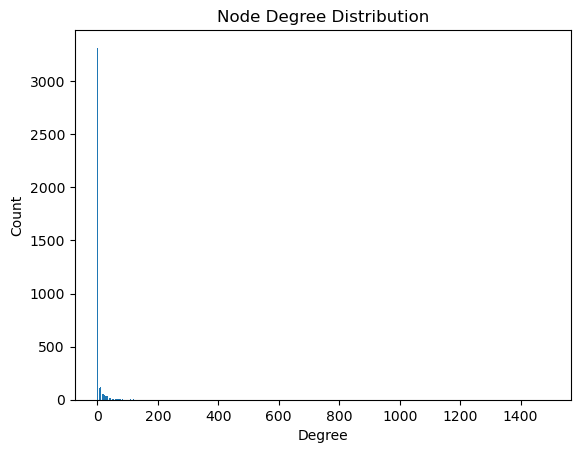

In [19]:
import pandas as pd
import matplotlib.pyplot as plt 
query = """
MATCH (streamer:TwitchUser)
RETURN size((streamer)-[:FOLLOWS]->()) AS degree, count(*) AS count
ORDER BY degree
"""
result = graph.run(query)

# Création d'un DataFrame pandas à partir des résultats de la requête
data = pd.DataFrame([dict(record) for record in result])

# Création de l'histogramme
plt.bar(data["degree"], data["count"])
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Node Degree Distribution')
plt.show()


 Oui, la distribution suit une loi de puissance: il y a beaucoup de streamers avec peu de collaborations et très peu de
streamers avec beaucoup de collaborations

### 3: How many streamers has the tag "mature" ?

In [27]:
query = """
MATCH (streamer:TwitchUser)
WHERE streamer.mature = 'True'
RETURN COUNT(streamer) AS mature_streamers
"""

result = graph.run(query)
record = result.next()
mature_streamers = record["mature_streamers"]

print("Nombre de streamers avec la propriété 'mature' définie à True:", mature_streamers)


Nombre de streamers avec la propriété 'mature' définie à True: 2416


### 4: Is the collaboration correlated to the "mature" tag ?

In [36]:
query_true = """
MATCH (streamer:TwitchUser {mature: 'True'})-[:FOLLOWS]->(other:TwitchUser)
RETURN COUNT(*) AS total_collaborations_true
"""

result_true = graph.run(query_true)

record_true = result_true.next()

# Nombre total de collaborations des streamers avec mature=True
total_collaborations_true = record_true["total_collaborations_true"]

query_false = """
MATCH (streamer:TwitchUser {mature: 'False'})-[:FOLLOWS]->(other:TwitchUser)
RETURN COUNT(*) AS total_collaborations_false
"""


result_false = graph.run(query_false)


record_false = result_false.next()

# Nombre total de collaborations des streamers avec mature=False
total_collaborations_false = record_false["total_collaborations_false"]


print("Nombre total de collaborations des streamers avec mature=True avec les autres:", total_collaborations_true)
print("Nombre total de collaborations des streamers avec mature=False avec les autres:", total_collaborations_false)


Nombre total de collaborations des streamers avec mature=True avec les autres: 33369
Nombre total de collaborations des streamers avec mature=False avec les autres: 52618


Dans le sous-echantillon que j'ai importé il apparait que les streamers
avec le tag mature False ont plus de collaborations que ceux avec le tag True.

### 5: Do partners collaborate more than non partners ?

In [43]:
query_true = """
MATCH (streamer:TwitchUser {partner: 'True'})-[:FOLLOWS]->(other:TwitchUser)
RETURN COUNT(*) AS total_collaborations_partners
"""

# Exécution de la requête Cypher
result_true = graph.run(query_true)

# Récupérer le premier enregistrement dans le curseur
record_true = result_true.next()

# Nombre total de collaborations des streamers avec partner=True
total_collaborations_partners = record_true["total_collaborations_partners"]

# Requête Cypher pour compter le nombre total de collaborations des streamers avec partner=False
query_false = """
MATCH (streamer:TwitchUser {partner: 'False'})-[:FOLLOWS]->(other:TwitchUser)
RETURN COUNT(*) AS total_collaborations_nonpartners
"""

# Exécution de la requête Cypher
result_false = graph.run(query_false)

# Récupérer le premier enregistrement dans le curseur
record_false = result_false.next()

# Nombre total de collaborations des streamers avec partner=False
total_collaborations_nonpartners = record_false["total_collaborations_nonpartners"]

# Affichage des résultats
print("Nombre total de collaborations des streamers avec partner=True avec les autres:", total_collaborations_partners)
print("Nombre total de collaborations des streamers avec partner=False avec les autres:", total_collaborations_nonpartners)



Nombre total de collaborations des streamers avec partner=True avec les autres: 29598
Nombre total de collaborations des streamers avec partner=False avec les autres: 56389


 Les streamers avec partner=False ont plus de collaborations que ceux avec partner=True (pour le sous-echantillon importé)

### 6: Sandbox exercise: think of a problematic and try to answer it.
### Le nombre de views est-il correlé au nombre de collaborations?

In [46]:
query = """
MATCH (streamer:TwitchUser)
OPTIONAL MATCH (streamer)-[:FOLLOWS]->(other:TwitchUser)
RETURN streamer.views AS views, COUNT(other) AS collaborations
"""

# Exécution de la requête Cypher
result = graph.run(query)

# Conversion des résultats en DataFrame pandas
data = pd.DataFrame([dict(record) for record in result])

# Conversion des colonnes en types numériques si nécessaire
data["collaborations"] = pd.to_numeric(data["collaborations"], errors='coerce')
data["views"] = pd.to_numeric(data["views"], errors='coerce')

# Suppression des lignes avec des valeurs manquantes
data.dropna(inplace=True)

# Calcul du coefficient de corrélation de Pearson entre collaborations et views
pearson_corr, _ = pearsonr(data["collaborations"], data["views"])
print(pearson_corr) 

# correlation de 0.4 entre le nombre de views et le nombre de collaborations, donc positive mais
# pas très forte

Type de données de la colonne 'collaborations': int64
Type de données de la colonne 'views': object
0.3755309782511905


### Real World application 6

You will work on a stackoverflow dataset found [here](https://www.kaggle.com/stackoverflow/stack-overflow-tag-network). First thing to do is create the network on Neo4j. You can find the characteristics of the nodes in stack_network_nodes.csv.
Once the node are create you can create the edges between them, you can find them in stack_network_links.csv. The weight of the edge is the column value. Answer the following making use of cypher queries.

1) What are the 10 most popular keywords ?

2) What are the top 10 Co-occurence ?

3) How many keywords are in group 1 ?

3) Is the Co-occurence correlated to the "group" of the keyword ?  

4) Sandbox exercise: think of a problematic and try to answer it.

In [28]:
import pandas as pd
from py2neo import Graph, Node, Relationship
csv_file = "C:/Users/Georgiana/Downloads/stack_network_nodes.csv"

data = pd.read_csv(csv_file)

# Connexion à la base de données Neo4j
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="stack")

# Créer les nœuds dans Neo4j à partir des données du fichier CSV
for index, row in data.iterrows():
    name = row['name']
    group = row['group']
    nodesize = row['nodesize']
    
    # Créer un nœud avec les attributs correspondants
    node = Node("Node", name=name, group=group, nodesize=nodesize)
    
    # Ajouter le nœud à la base de données
    graph.create(node)

In [29]:
from py2neo import Graph, NodeMatcher, Relationship
csv_links_file = "C:/Users/Georgiana/Downloads/stack_network_links.csv"

# Lire le fichier CSV des liens avec pandas
links_data = pd.read_csv(csv_links_file)
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="stack")

node_matcher = NodeMatcher(graph)
node_ids = {node["name"]: node.identity for node in node_matcher.match("Node")}

# Créer les arêtes dans Neo4j à partir des données du fichier CSV des liens
for index, row in links_data.iterrows():
    source_name = row['source']
    target_name = row['target']
    value = row['value']
    
    # Récupérer les ID des nœuds source et cible
    source_id = node_ids.get(source_name)
    target_id = node_ids.get(target_name)
    
    # Vérifier si les nœuds source et cible existent dans la base de données
    if source_id is not None and target_id is not None:
        # Créer la relation entre les nœuds source et cible avec le poids correspondant
        relation = Relationship(graph.nodes[source_id], "LINKS_TO", graph.nodes[target_id], weight=value)
        
        # Ajouter la relation à la base de données
        graph.create(relation)

### 1: What are the 10 most popular keywords ?

In [30]:
import py2neo
from py2neo import Graph, NodeMatcher, Relationship
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="stack")
query = """
MATCH (t)
RETURN t.name AS tag, sum(t.nodesize) AS popularite
ORDER BY popularite DESC
LIMIT 10
"""

# Exécution de la requête et récupération des résultats
result = graph.run(query)

# Affichage des résultats
for record in result:
    print(record["tag"], ":", record["popularite"])

javascript : 1947.48
java : 1831.9499999999998
python : 1316.01
php : 1083.66
css : 1023.51
c# : 963.39
html : 817.3499999999999
c++ : 804.33
android : 689.58
jquery : 624.87


### 2: What are the top 10 Co-occurence ?

### 3: How many keywords are in group 1 ?

In [37]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="stack")
query = """
MATCH (k1:Node)-[:LINKS_TO]-(k2:Node)
WHERE k1.name < k2.name
RETURN k1.name AS KeyWord1, k2.name AS KeyWord2, COUNT(*) AS co_occurrences
ORDER BY co_occurrences DESC
LIMIT 10
"""

# Exécution de la requête et récupération des résultats
result = graph.run(query)

# Affichage des résultats
for record in result:
    print(record["KeyWord1"], "and", record["KeyWord2"], ":", record["co_occurrences"], "co-occurrences")

html and jquery : 4 co-occurrences
html and php : 4 co-occurrences
html and mysql : 4 co-occurrences
html and sass : 4 co-occurrences
css and html : 4 co-occurrences
css and html5 : 4 co-occurrences
css and javascript : 4 co-occurrences
css and jquery : 4 co-occurrences
css and php : 4 co-occurrences
html and javascript : 4 co-occurrences


In [39]:
query = """
MATCH (n:Node)
WHERE n.group= 1
RETURN COUNT(n) AS keyword_count
"""

# Exécution de la requête et récupération du résultat
result = graph.run(query)

# Récupération du nombre de mots-clés dans le groupe 1 à partir du résultat
keyword_count = result.evaluate()

print("Nombre de mots-clés dans le groupe 1:", keyword_count)

Nombre de mots-clés dans le groupe 1: 30


### 4: Is the Co-occurence correlated to the "group" of the keyword ?

In [20]:
# co occurence dans le meme groupe:
query1 = """
MATCH (t1:Node)-[:LINKS_TO]->(t2:Node)
WHERE t1.group=t2.group
RETURN COUNT(*) AS co_occurrences_group
"""

# co occurence en dehors du meme groupe:
query2 = """
MATCH (t1:Node)-[:LINKS_TO]->(t2:Node)
WHERE t1.group<>t2.group
RETURN COUNT(*) AS co_occurrences_NONgroup
"""
result_group=graph.run(query1).evaluate()
result_groupNo=graph.run(query2).evaluate()
print("Co-occurence dans le meme groupe:", result_group)
print("Co-occurence dans le meme groupe:", result_groupNo)

Co-occurence dans le meme groupe: 440
Co-occurence dans le meme groupe: 50


### 5: Sandbox exercise: think of a problematic and try to answer it.
### Give the density of degrees.

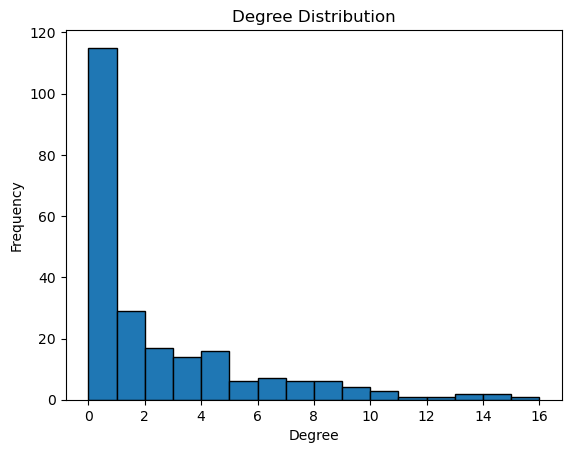

In [58]:
import matplotlib.pyplot as plt

query = """
MATCH (n)
RETURN size((n)-->()) AS degree
"""

result = graph.run(query)

# Extract degrees from the result
degrees = [record["degree"] for record in result]

# Plot the degree distribution
plt.hist(degrees, bins=range(min(degrees), max(degrees) + 1, 1), edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

Ca suit une loi de puissance.